In [1]:
!pip install "gymnasium[accept-rom-license]"

In [2]:
!pip install "gymnasium[atari]"
!pip install stable_baselines3
!pip install stable-baselines[mpi]

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [77 lines of output]
      
      
      WARNING, No "Setup" File Exists, Running "buildconfig/config.py"
      Using WINDOWS configuration...
      
      Making dir :prebuilt_downloads:
      Downloading... https://www.libsdl.org/release/SDL2-devel-2.0.16-VC.zip 13d952c333f3c2ebe9b7bc0075b4ad2f784e7584
      Unzipping :prebuilt_downloads\SDL2-devel-2.0.16-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_image/release/SDL2_image-devel-2.0.5-VC.zip 137f86474691f4e12e76e07d58d5920c8d844d5b
      Unzipping :prebuilt_downloads\SDL2_image-devel-2.0.5-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_ttf/release/SDL2_ttf-devel-2.0.15-VC.zip 1436df41ebc47ac36e02ec9bda5699e80ff9bd27
      Unzipping :prebuilt_downloads\SDL2_ttf-devel-2.0.15-VC.zip:
      Downloading... https://www.libsdl.org/projects/SDL_mixer/release/SDL2_mixer-devel-2.0.4-VC.zi


  Using cached stable_baselines-2.10.2-py3-none-any.whl.metadata (4.7 kB)
  Using cached mpi4py-3.1.6-cp311-cp311-win_amd64.whl.metadata (8.0 kB)
  Using cached pygame-2.1.0.tar.gz (5.8 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


In [3]:
# Common imports
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')
import ale_py
import shimmy
import numpy as np
import os
import gymnasium as gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.monitor import Monitor

#from stable_baselines3.common.policies import MlpPolicy
import optuna


c:\Users\raul\.conda\envs\noestructurados\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
log_dir = os.path.join(os.getcwd(),'logsA2C')

env = gym.make("ALE/AirRaid-v5",render_mode="rgb_array")
env = Monitor(env, log_dir)

In [5]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [14]:

def objective(trial):
    # Define los rangos para los parámetros que quieres optimizar
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    gamma = trial.suggest_uniform('gamma', 0.8, 0.99)
    gae_lambda = trial.suggest_uniform('gae_lambda', 0.1, 1.0)
    ent_coef = trial.suggest_uniform('ent_coef', 0.01, 0.9)
    vf_coef = trial.suggest_uniform('vf_coef', 0.1, 0.9)

    # Define el callback para guardar el mejor modelo
    callback = SaveOnBestTrainingRewardCallback(check_freq=1, log_dir=log_dir)

    # Crea el entorno y el modelo con los parámetros sugeridos por Optuna
    model = A2C(policy="MlpPolicy", env=env, learning_rate=learning_rate, gamma=gamma,
                gae_lambda=gae_lambda, ent_coef=ent_coef, vf_coef=vf_coef , verbose=0)

    # Entrena el modelo con un número limitado de pasos para evitar problemas de memoria
    model.learn(total_timesteps=1000, callback=callback)

    # Devuelve la recompensa promedio del modelo como el valor objetivo para Optuna
    return callback.best_mean_reward

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)

print("Best trial:")
trial = study.best_trial

print("Value: ", trial.value)

print("Params: ")


[I 2024-05-08 17:18:49,093] A new study created in memory with name: no-name-c71e9333-d501-4fbe-a1d3-558db2a5fd87
C:\Users\raul\AppData\Local\Temp\ipykernel_13364\2560474243.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\raul\AppData\Local\Temp\ipykernel_13364\2560474243.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.99)
C:\Users\raul\AppData\Local\Temp\ipykernel_13364\2560474243.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_

Num timesteps: 1
Best mean reward: -inf - Last mean reward per episode: 1100.00
Saving new best model to c:\Users\raul\Documents\GitHub\Reinforcement-Learning-Proyecto-Final\logsA2C\best_model.zip
Num timesteps: 2
Best mean reward: 1100.00 - Last mean reward per episode: 1100.00
Num timesteps: 3
Best mean reward: 1100.00 - Last mean reward per episode: 1100.00
Num timesteps: 4
Best mean reward: 1100.00 - Last mean reward per episode: 1100.00
Num timesteps: 5
Best mean reward: 1100.00 - Last mean reward per episode: 1100.00
Num timesteps: 6
Best mean reward: 1100.00 - Last mean reward per episode: 1100.00
Num timesteps: 7
Best mean reward: 1100.00 - Last mean reward per episode: 1100.00
Num timesteps: 8
Best mean reward: 1100.00 - Last mean reward per episode: 1100.00
Num timesteps: 9
Best mean reward: 1100.00 - Last mean reward per episode: 1100.00
Num timesteps: 10
Best mean reward: 1100.00 - Last mean reward per episode: 1100.00
Num timesteps: 11
Best mean reward: 1100.00 - Last mean

[I 2024-05-08 17:19:21,216] Trial 0 finished with value: 1100.0 and parameters: {'learning_rate': 8.504746324657656e-05, 'gamma': 0.9342301512935822, 'gae_lambda': 0.36255435865401997, 'ent_coef': 0.8294958493259585, 'vf_coef': 0.7721130152272629}. Best is trial 0 with value: 1100.0.


Num timesteps: 1000
Best mean reward: 1100.00 - Last mean reward per episode: 633.33


C:\Users\raul\AppData\Local\Temp\ipykernel_13364\2560474243.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\raul\AppData\Local\Temp\ipykernel_13364\2560474243.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.99)
C:\Users\raul\AppData\Local\Temp\ipykernel_13364\2560474243.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gae_lambda = trial.suggest_uniform('gae_lambda', 0.1, 1.0)
C:\Users\raul\AppData\Local\Temp\ipyke

Num timesteps: 1
Best mean reward: -inf - Last mean reward per episode: 633.33
Saving new best model to c:\Users\raul\Documents\GitHub\Reinforcement-Learning-Proyecto-Final\logsA2C\best_model.zip
Num timesteps: 2
Best mean reward: 633.33 - Last mean reward per episode: 633.33
Num timesteps: 3
Best mean reward: 633.33 - Last mean reward per episode: 633.33
Num timesteps: 4
Best mean reward: 633.33 - Last mean reward per episode: 633.33
Num timesteps: 5
Best mean reward: 633.33 - Last mean reward per episode: 633.33
Num timesteps: 6
Best mean reward: 633.33 - Last mean reward per episode: 633.33
Num timesteps: 7
Best mean reward: 633.33 - Last mean reward per episode: 633.33
Num timesteps: 8
Best mean reward: 633.33 - Last mean reward per episode: 633.33
Num timesteps: 9
Best mean reward: 633.33 - Last mean reward per episode: 633.33
Num timesteps: 10
Best mean reward: 633.33 - Last mean reward per episode: 633.33
Num timesteps: 11
Best mean reward: 633.33 - Last mean reward per episode:

[I 2024-05-08 17:19:50,998] Trial 1 finished with value: 633.3333333333334 and parameters: {'learning_rate': 6.682923335348751e-05, 'gamma': 0.8612870998717906, 'gae_lambda': 0.24358058951056794, 'ent_coef': 0.13531116614079974, 'vf_coef': 0.17958796578429492}. Best is trial 0 with value: 1100.0.


Num timesteps: 996
Best mean reward: 633.33 - Last mean reward per episode: 450.00
Num timesteps: 997
Best mean reward: 633.33 - Last mean reward per episode: 450.00
Num timesteps: 998
Best mean reward: 633.33 - Last mean reward per episode: 450.00
Num timesteps: 999
Best mean reward: 633.33 - Last mean reward per episode: 450.00
Num timesteps: 1000
Best mean reward: 633.33 - Last mean reward per episode: 450.00
Best trial:
Value:  1100.0
Params: 


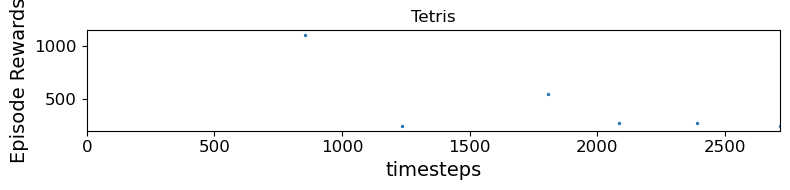

In [15]:
from stable_baselines3.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e4, results_plotter.X_TIMESTEPS, "Tetris"
)

In [ ]:
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

model = A2C.load(os.path.join(os.getcwd(),"logsA2C","best_model.zip"))
env_id = "ALE/AirRaid-v5"
video_folder  = os.path.join(os.getcwd(),'videosA2C')

video_length = 1814

vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])

obs = vec_env.reset()

# Record the video starting at the first step
vec_env = VecVideoRecorder(vec_env, video_folder,
                       record_video_trigger=lambda x: x == 0, video_length=video_length,
                       name_prefix=f"agent")
vec_env.reset()
for _ in range(video_length + 1):
  action, _states = model.predict(obs)
  print(action)
  obs, _, _, _ = vec_env.step(action)
# Save the video
vec_env.close()

c:\Users\raul\.conda\envs\noestructurados\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[5]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]
[1]


Moviepy - Done !
Moviepy - video ready c:\Users\raul\Documents\GitHub\Reinforcement-Learning-Proyecto-Final\videosA2C\agent-step-0-to-step-1814.mp4
[1]


In [ ]:
"""
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)


model = A2C.load("A2C_MARIOBROS")
obs, info = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    if terminated or truncated:
        obs, info = env.reset()
"""


'\ncallback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)\n\n\nmodel = A2C.load("A2C_MARIOBROS")\nobs, info = env.reset()\nwhile True:\n    action, _states = model.predict(obs, deterministic=True)\n    obs, reward, terminated, truncated, info = env.step(action)\n    if terminated or truncated:\n        obs, info = env.reset()\n'

In [ ]:
"""

episodes = 10

for ep in range(episodes):
    obs = env.reset()
    obs = obs[0]
    done = False
    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done, tr, info = env.step(action)
        env.render()
        print(rewards)
    """
